# Model

> API details.

In [ ]:
#|hide
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.chdir('/home/aucsie/Documents/practice')

In [ ]:
#|export
import cv2
import timm
import torch
import pickle
import random
import torch.nn as nn
from license_plate_detection.utils import *
from fastai.vision.all import *
from torchvision.ops import roi_align
from license_plate_detection.model import *
from license_plate_detection.model.rpn import *
from torchvision.ops import roi_align

In [ ]:
def pseudo_draw(anchors, im=None, size=128):
    if im is None: t = np.ones([size, size])
    else: t = im
    t = draw_bboxes(t, anchors)
    show_image(t)
    return t

In [ ]:
root= Path("/home/aucsie/Documents/practice/")
xb_path = root/'one_batch.pkl'
yb_path = root/'one_batch_yb.pkl'

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [ ]:
xb= CPU_Unpickler(open(xb_path, 'rb')).load()
yb= CPU_Unpickler(open(yb_path, 'rb')).load()

In [ ]:
arch= 'resnet50'

In [ ]:
device='cuda'
out_indices=[1, 2, 3, 4]
feature_channels=[256, 512, 1024, 2048]
# backbone= timm.create_model(arch, features_only=False, out_indices=out_indices)
# backbone= timm.create_model(arch, features_only=True, out_indices=out_indices)

In [ ]:
# features=backbone(xb)
# [f.shape for f in features]

In [ ]:
# fpn=FPN(feature_channels, out_indices)

In [ ]:
# fpn_feat = fpn(features)

In [ ]:
# for f in fpn_feat: print(f.shape)

In [ ]:
def draw_grid(img_shape, stride):
    im=np.zeros([*img_shape])
    x1=np.arange(0, img_shape[0], stride)
    y1=np.arange(0, img_shape[1], stride)
    for x in x1:
        for y in y1:
            cv2.line(im, (x,y), (x,img_shape[1]), (255,255,255), 1)
            cv2.line(im, (x,y), (img_shape[0], y), (255,255,255), 1)
    show_image(im, figsize=(6, 6))
    return im

In [ ]:
arch='resnet50'
input_sz= (1,3,128,128)
stride=16
ratios=[0.5, 1, 2]
scales=[16, 32, 64]

In [ ]:
def get_bbox(fp):
    #TODO refactor to dataclass coors
    bbox_str = Path(fp[0]).name.split("-")[2]
    bbox_str = list(map(int, re.findall("\d+", bbox_str)))
    return np.array(bbox_str)

In [ ]:
root = Path('./CCPD2019')
base_path = root/'ccpd_base'
dblock = DataBlock(blocks= (ImageBlock, BBoxBlock, BBoxLblBlock),
                   splitter= ColSplitter(),
                   get_x=ColReader(0, pref=root),
                   get_y=[get_bbox, lambda o: [0]],
                   item_tfms=Resize(128),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                   n_inp=1)

In [ ]:
df= pd.read_csv('./license_detector/exps/license_ds.csv')
df['is_valid']= df['split']=='train'
sub_df=df.groupby('split').apply(lambda x: x.sample(50))
sub_df=sub_df.reset_index(drop=True)

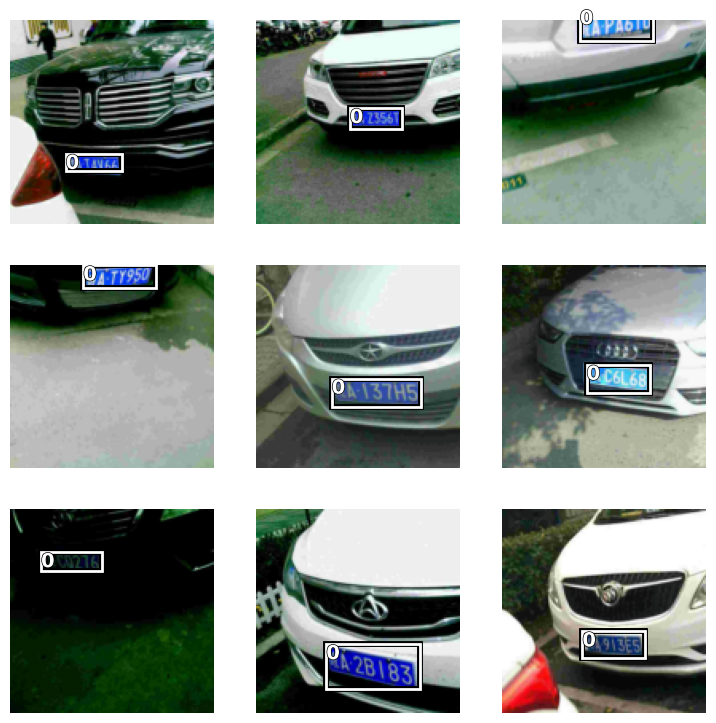

In [ ]:
dls= dblock.dataloaders(sub_df,bs=10)
dls.show_batch()

In [ ]:
arch='resnet50'
ratios=[1]
scales=[16,32]
nms_pre= 1000
nms_post= 80
nms_thr=0.5
model=FasterRCNN.init_model(arch, dls, ratios, scales, device).cuda()

In [ ]:
xb,bbox,lbls= dls.one_batch()

In [ ]:
x= model.backbone(xb)[0]

In [ ]:
rpn_reg_feats, rpn_cls_feats, rois= model.rpn_head(x)

In [ ]:
roi_reg_feats, roi_cls_feats= model.roi_head(x, rois)

In [ ]:
gt_rpn_cls, gt_rpn_reg= model.rpn_head.get_rpn_gt(bbox,128)

In [ ]:
gt_roi_cls, gt_roi_reg= model.roi_head.get_roi_gt(rois,bbox,lbls,128)

In [ ]:
roi_cls_feats.shape

torch.Size([10, 512, 2])

In [ ]:
val, ind= roi_cls_feats.max(dim=2)

In [ ]:
val=val.unsqueeze(-1)

In [ ]:
max_val, max_ind= torch.sort(val, dim=1, descending=True)

In [ ]:
max_val.shape

torch.Size([10, 512, 1])

In [ ]:
def decode_roi_preds(preds, all_anchors):
    rois, roi_reg_feats, roi_cls_feats= preds[2:]
    max_score, max_ind= roi_cls_feats.max(dim=-1)
    max_score= max_score.unsqueeze(-1)
    rois= rois[:,:,1:].contiguous()
    bboxes=[]
    for idx,_ in enumerate(roi_reg_feats):
        fg_max_score, fg_max_ind= max_score.sort(descending=True, dim=1)
        fg_max_ind= fg_max_ind[:1]
        bbox= reverse_offset(rois[idx,fg_max_ind.squeeze(1)], roi_reg_feats[idx,fg_max_ind.squeeze(1)])
        # bbox= torch.clamp(bbox, min=0, max=256)
        bbox= torch.hstack([bbox, fg_max_score[:1]])
        bboxes.append(TensorBBox(bbox))
    return torch.stack(bboxes)